<a href="https://colab.research.google.com/github/garfjohnson/Nba-Sports-Betting-Model/blob/master/NbaPredictionFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NBA Game Sports Betting Model
This model will use a rolling average of recent performance data for each team in an NBA matchup to predict each winner. The model will be trained on previous seasons and tested on the current 2019-20 NBA season. Vegas odds are incorporated and a hypothetical $100 bet is placed on every game. The results are very exciting.

## Import Libraries

In [214]:
# !pip install sportsreference
from sportsreference.nba.schedule import Schedule
from datetime import datetime
from sportsreference.nba.boxscore import Boxscores, Boxscore
from sportsreference.nba.teams import Teams
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
# from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

In [215]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [216]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import normalize, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, f1_score

## Declare Useful Functions and Lists

In [217]:
## this function combines our cleaning step into one easy function
def format_nba_df(df):
  ## create a bool column for home win
  df['homeWin'] = df['winner'] == 'Home'
  ## rename unnamed column to gameid
  df = df.rename(columns={'Unnamed: 0': 'gameID'})
  ## create datetime object from column of date strings and drop the time 
  df['date'] = df['date'].apply(lambda x: (datetime.strptime(x, '%I:%M %p, %B %d, %Y')).date())
  ## create home team column
  df['homeTeam'] = np.where(df['homeWin']==True, df['winning_abbr'], df['losing_abbr'])
  ## create away team column
  df['awayTeam'] = np.where(df['homeWin']==False, df['winning_abbr'], df['losing_abbr'])
  return df

In [218]:
## this takes an odds dataframe and converts the date to a datetime object, year must be specified
def convert_to_datetime(x, year):
  y = str(x)
  if x < 1000:
    date = datetime(year=year, month=int(y[:-2]), day=int(y[-2:]))
    return date.strftime("%Y-%m-%d")
  else:
    date = datetime(year=year-1, month=int(y[:-2]), day=int(y[-2:]))
    return date.strftime("%Y-%m-%d")

In [219]:
def avg_previous_num_games(df, num_games):
  ### This function changes each stat to be the average of the last num_games for each team, and shifts it one so it does not include the current stats and drops the first num_games that become null
  for col in home_cols:
    for team in team_list:
      df[col].loc[df['homeTeam']==team] = df[col].loc[df['homeTeam']==team].shift(1).rolling(num_games, min_periods=3).mean()
  for col in away_cols:
    for team in team_list:
      df[col].loc[df['awayTeam']==team] = df[col].loc[df['awayTeam']==team].shift(1).rolling(num_games, min_periods=3).mean()
  return df.dropna()

In [220]:
# seperate statistical columns to home and away for later
away_cols = ['away_assist_percentage', 'away_assists',
       'away_block_percentage', 'away_blocks', 'away_defensive_rating',
       'away_defensive_rebound_percentage', 'away_defensive_rebounds',
       'away_effective_field_goal_percentage', 'away_field_goal_attempts',
       'away_field_goal_percentage', 'away_field_goals',
       'away_free_throw_attempt_rate', 'away_free_throw_attempts',
       'away_free_throw_percentage', 'away_free_throws','away_minutes_played', 'away_offensive_rating',
       'away_offensive_rebound_percentage', 'away_offensive_rebounds',
       'away_personal_fouls', 'away_points', 'away_steal_percentage',
       'away_steals', 'away_three_point_attempt_rate',
       'away_three_point_field_goal_attempts',
       'away_three_point_field_goal_percentage',
       'away_three_point_field_goals', 'away_total_rebound_percentage',
       'away_total_rebounds', 'away_true_shooting_percentage',
       'away_turnover_percentage', 'away_turnovers',
       'away_two_point_field_goal_attempts',
       'away_two_point_field_goal_percentage', 'away_two_point_field_goals']
home_cols = ['home_assist_percentage', 'home_assists',
       'home_block_percentage', 'home_blocks', 'home_defensive_rating',
       'home_defensive_rebound_percentage', 'home_defensive_rebounds',
       'home_effective_field_goal_percentage', 'home_field_goal_attempts',
       'home_field_goal_percentage', 'home_field_goals',
       'home_free_throw_attempt_rate', 'home_free_throw_attempts',
       'home_free_throw_percentage', 'home_free_throws',
       'home_minutes_played', 'home_offensive_rating',
       'home_offensive_rebound_percentage', 'home_offensive_rebounds',
       'home_personal_fouls', 'home_points', 'home_steal_percentage',
       'home_steals', 'home_three_point_attempt_rate',
       'home_three_point_field_goal_attempts',
       'home_three_point_field_goal_percentage',
       'home_three_point_field_goals', 'home_total_rebound_percentage',
       'home_total_rebounds', 'home_true_shooting_percentage',
       'home_turnover_percentage', 'home_turnovers',
       'home_two_point_field_goal_attempts',
       'home_two_point_field_goal_percentage', 'home_two_point_field_goals']

## Load and Arrange the Data
We'll load the stats and odds datasets and ensure they are formatted the same and have the same shape so we can combine them later.

In [221]:

nba2015 = pd.read_csv(r"nba2015-16.csv")
nba2016 = pd.read_csv(r"nba2016-17.csv")
# load 2017-18 boxscore stats
nba2017 = pd.read_csv(r"nba2017-18.csv")
# load 2018-19 boxscore stats
nba2018 = pd.read_csv(r"nba2018-19.csv")
# load 2019-20 boxscore stats
nbaCurrent = pd.read_csv(r'nba2019-20.csv')

In [222]:
# apply cleaning step
nba2015 = format_nba_df(nba2015)
nba2016 = format_nba_df(nba2016)
nba2017 = format_nba_df(nba2017)
nba2018 = format_nba_df(nba2018)
nbaCurrent = format_nba_df(nbaCurrent)

In [223]:
odds2015 = pd.read_csv(r"nbaodds2015-16.csv")
odds2016 = pd.read_csv(r"nbaodds2016-17.csv")
# load 2017-18 odds
odds2017 = pd.read_csv(r"nbaodds2017-18.csv")
# load 2018-19 odds
odds2018 = pd.read_csv(r"nbaodds2018-19.csv")
# load 2019-20 odds
oddsCurrent = pd.read_csv(r"nbaodds2019-20.csv")

In [224]:
## create list of team abbreviations and sort them
team_list = sorted(list(nba2015['homeTeam'].unique()))

##### Here we format our odds df to match our main df by:
1. Finding the neutral site game for each season and setting the corresponding team to the home team
2. Dropping playoff games
3. Seperating home/away team and get the home vs away in the same row
3. Changing the date column to datetime objects
4. Change team names to abbreviations
5. Sort by date then by team to line up the two dfs

I'll be keeping the odds dfs seperate for now because they'll be attached to each corresponding nba df which will need to remain seperated by season before being transformed.

In [225]:
## one game played in london
odds2015['VH'].unique()

array(['V', 'H', 'N'], dtype=object)

In [226]:
## no neutral sites yet
oddsCurrent['VH'].unique()

array(['V', 'H'], dtype=object)

In [227]:
## we need to change these to home and away so it matches our other df
odds2015.loc[odds2015['VH']=='N']

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
560,1203,709,N,Boston,32,19,39,24,114,2,2.5,-140,110
561,1203,710,N,Sacramento,17,19,32,29,97,212.5,216.5,120,3.5
1172,114,701,N,Toronto,31,30,16,19,106,3,4.5,-200,pk
1173,114,702,N,Orlando,18,36,19,23,103,194,193.5,170,97.5


In [230]:
## change values for home and away team
odds2015['VH'].iloc[[1233]] = 'H'
odds2015['VH'].iloc[[1232]] = 'V'

C:\Users\Jason Huang\AppData\Local\Temp\ipykernel_11944\554996046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odds2015['VH'].iloc[[1233]] = 'H'
C:\Users\Jason Huang\AppData\Local\Temp\ipykernel_11944\554996046.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odds2015['VH'].iloc[[1232]] = 'V'


In [231]:
## check work
odds2015.iloc[[1232,1233]]

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
1232,118,505,V,Portland,32,27,35,14,108,215,208.5,155,103
1233,118,506,H,Washington,17,40,19,22,98,5,4,-175,3.5


In [232]:
odds2016.loc[odds2016['VH']=='N']
odds2017.loc[odds2017['VH']=='N']
## do the same for 2018 df
odds2018.loc[odds2018['VH']=='N']

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
1328,117,541,N,NewYork,30,33,26,11,100,225,229,260,112.5
1329,117,542,N,Washington,20,33,24,24,101,7,7.5,-330,7.5


In [234]:
odds2016['VH'].iloc[[1329]] = 'H'
odds2016['VH'].iloc[[1328]] = 'V'
odds2017['VH'].iloc[[1329]] = 'H'
odds2017['VH'].iloc[[1328]] = 'V'
## change the value for home and away team
odds2018['VH'].iloc[[1329]] = 'H'
odds2018['VH'].iloc[[1328]] = 'V'

C:\Users\Jason Huang\AppData\Local\Temp\ipykernel_11944\2080901717.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odds2016['VH'].iloc[[1329]] = 'H'
C:\Users\Jason Huang\AppData\Local\Temp\ipykernel_11944\2080901717.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odds2016['VH'].iloc[[1328]] = 'V'
C:\Users\Jason Huang\AppData\Local\Temp\ipykernel_11944\2080901717.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odds2017['VH']

In [236]:
## check work
odds2016.iloc[[1328,1329]]
odds2017.iloc[[1328,1329]]
odds2018.iloc[[1328,1329]]

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
1328,117,541,V,NewYork,30,33,26,11,100,225,229,260,112.5
1329,117,542,H,Washington,20,33,24,24,101,7,7.5,-330,7.5


In [237]:
## convert to datetime object
odds2015['date'] = odds2015['Date'].apply(lambda x: convert_to_datetime(x, 2016))
odds2016['date'] = odds2016['Date'].apply(lambda x: convert_to_datetime(x, 2016))
odds2017['date'] = odds2017['Date'].apply(lambda x: convert_to_datetime(x, 2018))
odds2018['date'] = odds2018['Date'].apply(lambda x: convert_to_datetime(x, 2019))
oddsCurrent['date'] = oddsCurrent['Date'].apply(lambda x: convert_to_datetime(x, 2020))

In [238]:
## team name to team abbrev dict for mapping
team_dict = {'Atlanta':'ATL', 'Boston':'BOS', 'Brooklyn':'BRK','Charlotte':'CHO','Chicago':'CHI','Cleveland':'CLE','Dallas':'DAL', 'Denver':'DEN','Detroit':'DET',
             'GoldenState':'GSW', 'Houston':'HOU', 'Indiana':'IND','LAClippers':'LAC','LALakers':'LAL','Memphis':'MEM','Miami':'MIA','Milwaukee':'MIL','Minnesota':'MIN',
             'NewOrleans':'NOP','NewYork':'NYK','OklahomaCity':'OKC','Orlando':'ORL','Philadelphia':'PHI','Phoenix':'PHO','Portland':'POR','Sacramento':'SAC',
             'SanAntonio':'SAS','Toronto':'TOR','Utah':'UTA','Washington':'WAS'}
## change team names to abbrevs
odds2015['Team'] = odds2015['Team'].map(team_dict)
odds2016['Team'] = odds2016['Team'].map(team_dict)
odds2017['Team'] = odds2017['Team'].map(team_dict)
odds2018['Team'] = odds2018['Team'].map(team_dict)
oddsCurrent['Team'] = oddsCurrent['Team'].map(team_dict)

In [239]:
## seperate into home and away and drop playoff games
## seperate into home and away and drop playoff games
homeOdds2015 = odds2015.loc[odds2015['VH']=='H'].reset_index(drop=True)[:1230]
awayOdds2015 = odds2015.loc[odds2015['VH']=='V'].reset_index(drop=True)[:1230]

homeOdds2016 = odds2016.loc[odds2016['VH']=='H'].reset_index(drop=True)[:1230]
awayOdds2016 = odds2016.loc[odds2016['VH']=='V'].reset_index(drop=True)[:1230]

homeOdds2017 = odds2017.loc[odds2017['VH']=='H'].reset_index(drop=True)[:1230]
awayOdds2017 = odds2017.loc[odds2017['VH']=='V'].reset_index(drop=True)[:1230]

homeOdds2018 = odds2018.loc[odds2018['VH']=='H'].reset_index(drop=True)[:1230]
awayOdds2018 = odds2018.loc[odds2018['VH']=='V'].reset_index(drop=True)[:1230]

homeOddsCurrent = oddsCurrent.loc[oddsCurrent['VH']=='H'].reset_index(drop=True)
awayOddsCurrent = oddsCurrent.loc[oddsCurrent['VH']=='V'].reset_index(drop=True)

In [240]:
# rename home columns
homeOdds2015 = homeOdds2015.rename(columns={'Team': 'homeTeam', 'ML': 'homeOdds'})
homeOdds2016 = homeOdds2016.rename(columns={'Team': 'homeTeam', 'ML': 'homeOdds'})
homeOdds2017 = homeOdds2017.rename(columns={'Team': 'homeTeam', 'ML': 'homeOdds'})
homeOdds2018 = homeOdds2018.rename(columns={'Team': 'homeTeam', 'ML': 'homeOdds'})
homeOddsCurrent = homeOddsCurrent.rename(columns={'Team': 'homeTeam', 'ML': 'homeOdds'})

# rename away columns
awayOdds2015 = awayOdds2015.rename(columns={'Team': 'awayTeam', 'ML': 'awayOdds'})
awayOdds2016 = awayOdds2016.rename(columns={'Team': 'awayTeam', 'ML': 'awayOdds'})
awayOdds2017 = awayOdds2017.rename(columns={'Team': 'awayTeam', 'ML': 'awayOdds'})
awayOdds2018 = awayOdds2018.rename(columns={'Team': 'awayTeam', 'ML': 'awayOdds'})
awayOddsCurrent = awayOddsCurrent.rename(columns={'Team': 'awayTeam', 'ML': 'awayOdds'})

In [241]:
## create half of the combined df
combinedOdds2015 = homeOdds2015[['date','homeTeam','homeOdds']]
combinedOdds2016 = homeOdds2016[['date','homeTeam','homeOdds']]
combinedOdds2017 = homeOdds2017[['date','homeTeam','homeOdds']]
combinedOdds2018 = homeOdds2018[['date','homeTeam','homeOdds']]
combinedOddsCurrent = homeOddsCurrent[['date','homeTeam','homeOdds']]

In [242]:
## add in away columns
combinedOdds2015['awayOdds'] = awayOdds2015['awayOdds']
combinedOdds2015['awayTeam'] = awayOdds2015['awayTeam']

combinedOdds2016['awayOdds'] = awayOdds2016['awayOdds']
combinedOdds2016['awayTeam'] = awayOdds2016['awayTeam']

combinedOdds2017['awayOdds'] = awayOdds2017['awayOdds']
combinedOdds2017['awayTeam'] = awayOdds2017['awayTeam']

combinedOdds2018['awayOdds'] = awayOdds2018['awayOdds']
combinedOdds2018['awayTeam'] = awayOdds2018['awayTeam']

combinedOddsCurrent['awayOdds'] = awayOddsCurrent['awayOdds']
combinedOddsCurrent['awayTeam'] = awayOddsCurrent['awayTeam']

C:\Users\Jason Huang\AppData\Local\Temp\ipykernel_11944\3978491057.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combinedOdds2015['awayOdds'] = awayOdds2015['awayOdds']
C:\Users\Jason Huang\AppData\Local\Temp\ipykernel_11944\3978491057.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combinedOdds2015['awayTeam'] = awayOdds2015['awayTeam']
C:\Users\Jason Huang\AppData\Local\Temp\ipykernel_11944\3978491057.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [243]:
## sort odds df to line both dfs up
sortedOdds2015 = combinedOdds2015.sort_values(by=['date','homeTeam'])

sortedOdds2016 = combinedOdds2016.sort_values(by=['date','homeTeam'])

sortedOdds2017 = combinedOdds2017.sort_values(by=['date','homeTeam'])

sortedOdds2018 = combinedOdds2018.sort_values(by=['date','homeTeam'])

sortedOddsCurrent = combinedOddsCurrent.sort_values(by=['date','homeTeam'])

In [244]:
## sort nba df
sortedNba2015 = nba2015.sort_values(by=['date','homeTeam'])
sortedNba2016 = nba2016.sort_values(by=['date','homeTeam'])
sortedNba2017 = nba2017.sort_values(by=['date','homeTeam'])
sortedNba2018 = nba2018.sort_values(by=['date','homeTeam'])
sortedNbaCurrent = nbaCurrent.sort_values(by=['date','homeTeam'])

We have more recent data for the current NBA results right now than for the odds, so I'll drop the extra to give them the same shape.

In [245]:
sortedNbaCurrent.shape

(805, 86)

In [246]:
sortedOddsCurrent.shape

(692, 5)

In [247]:
sortedNbaCurrent = sortedNbaCurrent[:692]

In [248]:
sortedNbaCurrent.shape

(692, 86)

In [249]:
sortedOddsCurrent.tail(10)

,date,homeTeam,homeOdds,awayOdds,awayTeam
683,2020-01-25,PHI,185,-230,LAL
679,2020-01-25,UTA,-210,175,DAL
690,2020-01-26,ATL,-115,-105,WAS
684,2020-01-26,DEN,-140,120,HOU
687,2020-01-26,MEM,-135,115,PHO
686,2020-01-26,NOP,-125,105,BOS
689,2020-01-26,NYK,-140,120,BRK
688,2020-01-26,ORL,135,-155,LAC
691,2020-01-26,POR,-150,130,IND
685,2020-01-26,SAS,145,-170,TOR


In [250]:
sortedNbaCurrent[['date','homeTeam','awayTeam']].tail(10)

,date,homeTeam,awayTeam
682,2020-01-25,PHI,LAL
683,2020-01-25,UTA,DAL
684,2020-01-26,ATL,WAS
685,2020-01-26,DEN,HOU
686,2020-01-26,MEM,PHO
687,2020-01-26,NOP,BOS
688,2020-01-26,NYK,BRK
689,2020-01-26,ORL,LAC
690,2020-01-26,POR,IND
691,2020-01-26,SAS,TOR


##### Now that the two dfs have the exact same shape and format, it's time to tack on the money line column.

In [251]:
## add home and away money line column
sortedNba2015['homeOdds'] = sortedOdds2015['homeOdds']
sortedNba2015['awayOdds'] = sortedOdds2015['awayOdds']

sortedNba2016['homeOdds'] = sortedOdds2016['homeOdds']
sortedNba2016['awayOdds'] = sortedOdds2016['awayOdds']

sortedNba2017['homeOdds'] = sortedOdds2017['homeOdds']
sortedNba2017['awayOdds'] = sortedOdds2017['awayOdds']

sortedNba2018['homeOdds'] = sortedOdds2018['homeOdds']
sortedNba2018['awayOdds'] = sortedOdds2018['awayOdds']

sortedNbaCurrent['homeOdds'] = sortedOddsCurrent['homeOdds']
sortedNbaCurrent['awayOdds'] = sortedOddsCurrent['awayOdds']

In [252]:
sortedNbaCurrent[['date','homeTeam','awayTeam','homeOdds','awayOdds']].tail(10)

,date,homeTeam,awayTeam,homeOdds,awayOdds
682,2020-01-25,PHI,LAL,-125,105
683,2020-01-25,UTA,DAL,185,-230
684,2020-01-26,ATL,WAS,-140,120
685,2020-01-26,DEN,HOU,145,-170
686,2020-01-26,MEM,PHO,-125,105
687,2020-01-26,NOP,BOS,-135,115
688,2020-01-26,NYK,BRK,135,-155
689,2020-01-26,ORL,LAC,-140,120
690,2020-01-26,POR,IND,-115,-105
691,2020-01-26,SAS,TOR,-150,130


## Transform the Data
Currently, each row represents a box score of a completed game. Since we obviously don't have access to that information when predicting, each statistical feature will become the rolling average of the previous X games. I kept the two seasons' dfs seperate so that performance from the previous season wasn't included. The first X games of each season are dropped since there isn't enough information.

After testing 1-7 games, 3 has been performing the best. 2-4 all performed similarly but more than that was a clear drop in performance. 

Another note: the rolling average is from the previous X home or away games for that team. This accounts for teams' road vs away performance but could lose some performance where a team is playing their first home game after many road games and vice versa.

In [253]:
## apply our transformation
avg2015 = avg_previous_num_games(sortedNba2015, 3)
avg2016 = avg_previous_num_games(sortedNba2016, 3)
avg2017 = avg_previous_num_games(sortedNba2017, 3)
avg2018 = avg_previous_num_games(sortedNba2018, 3)
nba_test = avg_previous_num_games(sortedNbaCurrent, 3)

C:\Users\Jason Huang\AppData\Local\Temp\ipykernel_11944\261196598.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].loc[df['homeTeam']==team] = df[col].loc[df['homeTeam']==team].shift(1).rolling(num_games, min_periods=3).mean()


C:\Users\Jason Huang\AppData\Local\Temp\ipykernel_11944\261196598.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].loc[df['awayTeam']==team] = df[col].loc[df['awayTeam']==team].shift(1).rolling(num_games, min_periods=3).mean()


In [254]:
nba_test.shape

(590, 88)

In [255]:
nba_test.reset_index(drop=True, inplace=True)

In [256]:
## combine the two dfs
nba_final = pd.concat([avg2015,avg2016,avg2017, avg2018])

In [257]:
nba_final.shape

(4499, 88)

In [258]:
nba_final.head()

,gameID,away_assist_percentage,away_assists,away_block_percentage,away_blocks,away_defensive_rating,away_defensive_rebound_percentage,away_defensive_rebounds,away_effective_field_goal_percentage,away_field_goal_attempts,away_field_goal_percentage,away_field_goals,away_free_throw_attempt_rate,away_free_throw_attempts,away_free_throw_percentage,away_free_throws,away_losses,away_minutes_played,away_offensive_rating,away_offensive_rebound_percentage,away_offensive_rebounds,away_personal_fouls,away_points,away_steal_percentage,away_steals,away_three_point_attempt_rate,away_three_point_field_goal_attempts,away_three_point_field_goal_percentage,away_three_point_field_goals,away_total_rebound_percentage,away_total_rebounds,away_true_shooting_percentage,away_turnover_percentage,away_turnovers,away_two_point_field_goal_attempts,away_two_point_field_goal_percentage,away_two_point_field_goals,away_wins,date,home_assist_percentage,home_assists,home_block_percentage,home_blocks,home_defensive_rating,home_defensive_rebound_percentage,home_defensive_rebounds,home_effective_field_goal_percentage,home_field_goal_attempts,home_field_goal_percentage,home_field_goals,home_free_throw_attempt_rate,home_free_throw_attempts,home_free_throw_percentage,home_free_throws,home_losses,home_minutes_played,home_offensive_rating,home_offensive_rebound_percentage,home_offensive_rebounds,home_personal_fouls,home_points,home_steal_percentage,home_steals,home_three_point_attempt_rate,home_three_point_field_goal_attempts,home_three_point_field_goal_percentage,home_three_point_field_goals,home_total_rebound_percentage,home_total_rebounds,home_true_shooting_percentage,home_turnover_percentage,home_turnovers,home_two_point_field_goal_attempts,home_two_point_field_goal_percentage,home_two_point_field_goals,home_wins,location,losing_abbr,losing_name,pace,winner,winning_abbr,winning_name,homeWin,homeTeam,awayTeam,homeOdds,awayOdds
77,201511060GSW,63.966667,25.333333,11.933333,6.666667,106.633333,70.700000,33.000000,0.521667,85.333333,0.464000,39.333333,0.266667,22.666667,0.758333,17.666667,4,240.000000,108.833333,26.233333,11.333333,22.000000,106.000000,7.566667,7.333333,0.286667,24.333333,0.392333,9.666667,49.666667,44.333333,0.558333,14.466667,16.000000,61.000000,0.489000,29.666667,2,2015-11-06,72.300000,22.000000,12.066667,4.666667,91.300000,80.466667,29.666667,0.523000,89.000000,0.394000,34.666667,0.317000,23.000000,0.680000,15.666667,0,240.0,114.466667,30.500000,9.666667,25.333333,114.000000,7.366667,7.666667,0.305667,21.000000,0.275667,5.666667,57.700000,39.333333,0.568333,13.100000,13.333333,68.000000,0.430333,29.000000,6,"Oracle Arena, Oakland, California",DEN,Denver Nuggets,107.4,Home,GSW,Golden State Warriors,True,GSW,DEN,-1650,950
84,201511070ATL,62.266667,21.666667,10.900000,7.333333,104.266667,73.200000,32.666667,0.497667,80.000000,0.439000,34.666667,0.402000,30.666667,0.733667,23.000000,3,240.000000,100.100000,24.033333,11.000000,20.333333,101.333333,8.200000,8.333333,0.308667,24.666667,0.380333,9.000000,48.733333,43.666667,0.545667,18.100000,20.666667,55.333333,0.465667,25.666667,3,2015-11-07,65.466667,23.333333,9.666667,4.333333,101.066667,66.533333,35.333333,0.507000,89.000000,0.409333,36.333333,0.254667,17.333333,0.769000,13.333333,1,240.0,103.000000,16.566667,16.666667,18.000000,97.333333,11.700000,7.000000,0.298333,26.666667,0.350667,9.666667,43.366667,52.000000,0.545333,13.833333,17.333333,62.333333,0.429000,26.666667,7,"Philips Arena, Atlanta, Georgia",WAS,Washington Wizards,99.7,Home,ATL,Atlanta Hawks,True,ATL,WAS,-475,380
88,201511070MIL,58.933333,20.666667,7.366667,4.333333,110.533333,76.800000,31.333333,0.466333,79.666667,0.439333,35.000000,0.193333,15.333333,0.656333,10.000000,7,240.000000,92.233333,19.366667,8.000000,19.333333,84.333333,6.533333,6.000000,0.208667,16.666667,0.260667,4.333333,47.600000,39.333333,0.487333,14.966667,15.333333,63.000000,0.485333,30.666667,0,2015-11-07,67.966667,24.000000,5.833333,7.000000,113.666667,68.966667,32.66

## Initial DBA
Let's poke around our data.

##### As seen below, the money line feature needs to be normalized, which we'll do to all our features to be safe.

c:\Users\Jason Huang\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='homeOdds', ylabel='Density'>

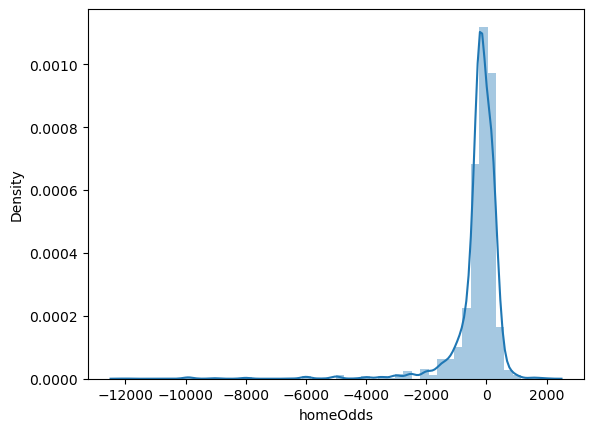

In [259]:
## home money line distribution
sns.distplot(nba_final['homeOdds'])

c:\Users\Jason Huang\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='awayOdds', ylabel='Density'>

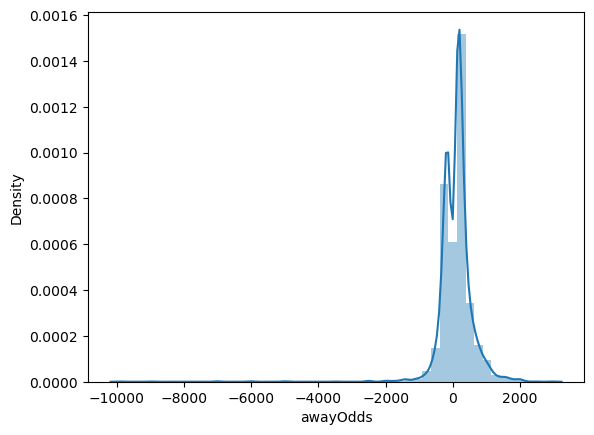

In [260]:
## away money line distribution
sns.distplot(nba_final['awayOdds'])

c:\Users\Jason Huang\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='home_points', ylabel='Density'>

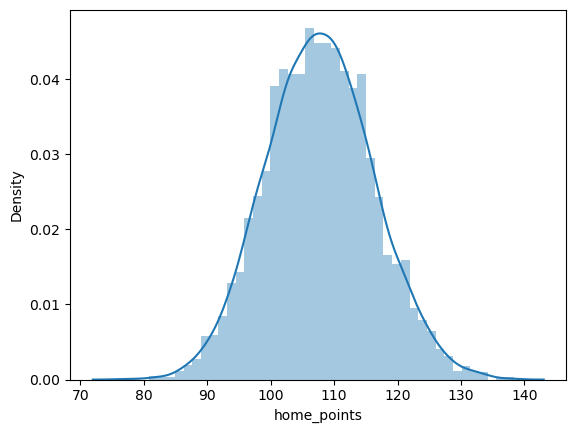

In [261]:
## points distribution
sns.distplot(nba_final['home_points'])

##### Our correlations all seem logical with the away team win total and the home team loss total being the strongest negative correlation to a home win -- essentially representing which team has had more success so far that season.

In [262]:
## get correlations to win
winCorr = nba_final.corr()['homeWin'].sort_values(ascending=False)

In [263]:
## top 10 correlations to home win
winCorr.head(10)

homeWin                                 1.000000
home_wins                               0.157571
home_offensive_rating                   0.157481
home_true_shooting_percentage           0.131370
away_losses                             0.131317
home_effective_field_goal_percentage    0.129818
home_points                             0.129391
home_total_rebound_percentage           0.092577
away_defensive_rating                   0.079232
away_two_point_field_goal_attempts      0.069018
Name: homeWin, dtype: float64

In [264]:
## bottom 10 correlations to home win
winCorr.tail(10)

away_three_point_attempt_rate   -0.075997
away_true_shooting_percentage   -0.076945
home_defensive_rating           -0.077303
away_offensive_rating           -0.080502
away_three_point_field_goals    -0.081179
home_total_rebounds             -0.086116
home_defensive_rebounds         -0.093291
home_blocks                     -0.101524
away_wins                       -0.152660
home_losses                     -0.165788
Name: homeWin, dtype: float64

<AxesSubplot:>

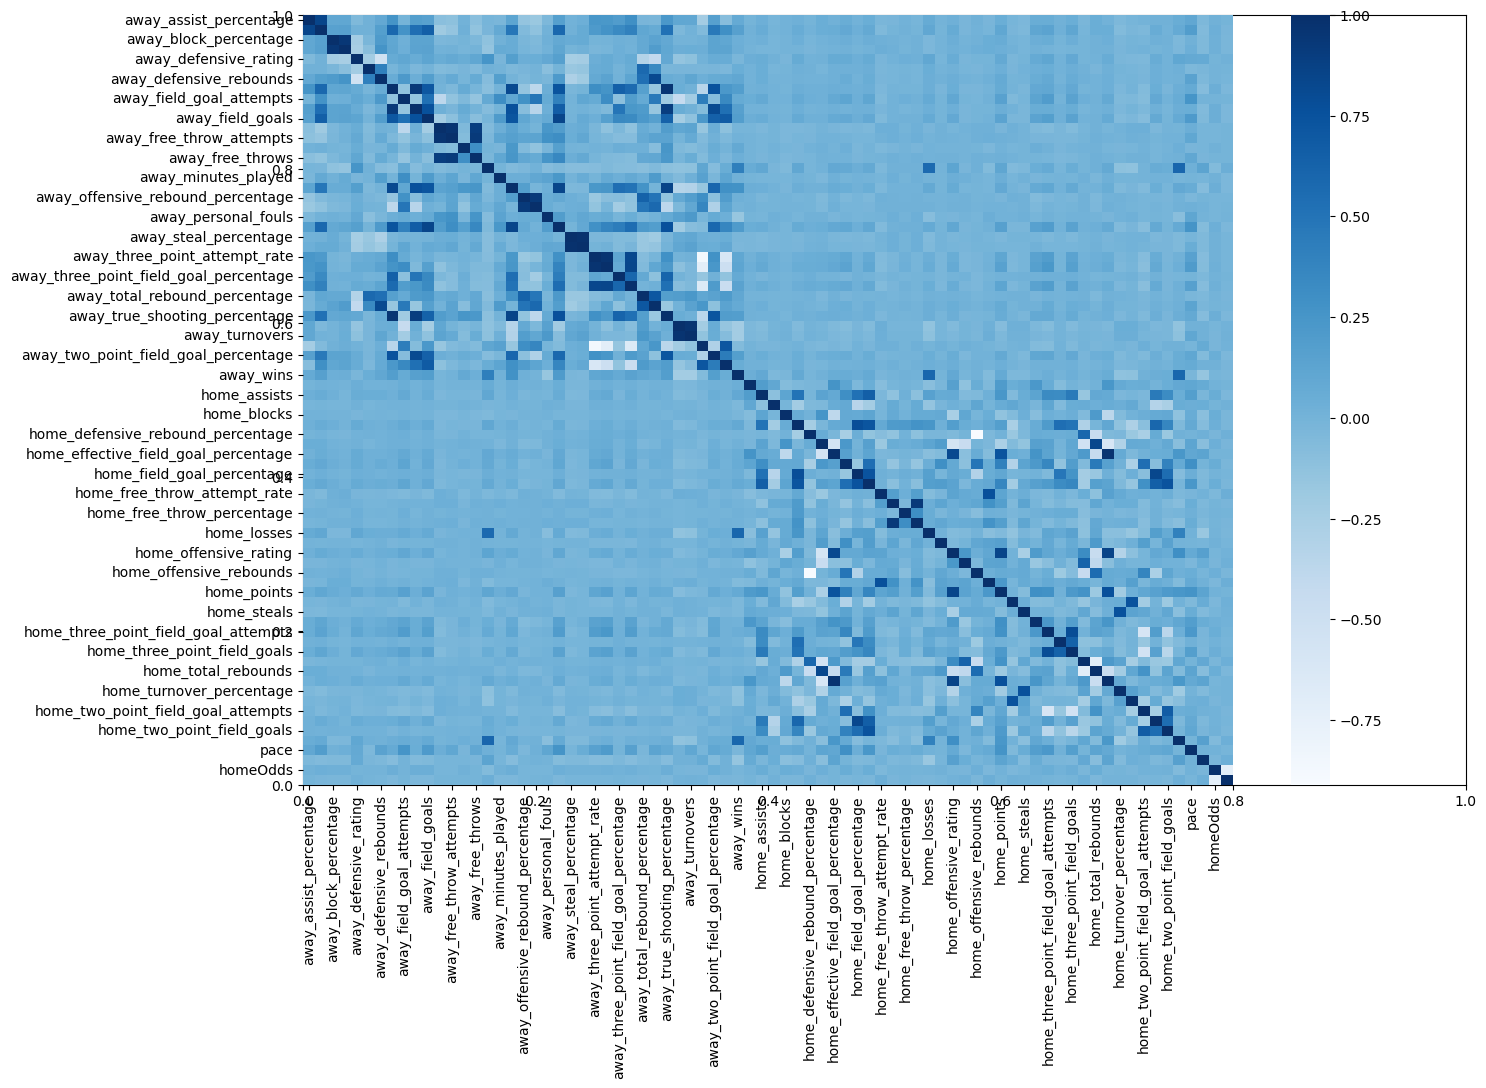

In [265]:
# Correlation heatmap
plt.subplots(figsize=(15,10))
ax = plt.axes()
corr = nba_final.corr()
sns.heatmap(corr,cmap = "Blues")

##### We have high collinearity among some of our features, mostly in cases where there's a total and a percentage value for one statistic. If we we're going to build a regression model we'd need to address this, but for our classifier, it shouldn't impact predictive performance.

In [266]:
## list of the top 25 positive correlations
top25_corr_pos = nba_final.corr().unstack().sort_values(ascending=False).drop_duplicates()
top25_corr_pos.head(25)

away_assist_percentage                away_assist_percentage                  1.000000
away_steals                           away_steal_percentage                   0.984007
away_turnovers                        away_turnover_percentage                0.966014
away_three_point_attempt_rate         away_three_point_field_goal_attempts    0.965467
away_free_throw_attempts              away_free_throw_attempt_rate            0.964903
home_effective_field_goal_percentage  home_true_shooting_percentage           0.963131
away_true_shooting_percentage         away_effective_field_goal_percentage    0.961644
away_blocks                           away_block_percentage                   0.940861
home_free_throw_attempts              home_free_throws                        0.930636
away_field_goal_percentage            away_effective_field_goal_percentage    0.928510
away_offensive_rebounds               away_offensive_rebound_percentage       0.923081
away_free_throws                      away_

In [267]:
## list of the top 25 negative correlations
top25_corr_neg = nba_final.corr().unstack().sort_values().drop_duplicates()
top25_corr_neg.head(25)

home_offensive_rebounds               home_defensive_rebound_percentage      -0.911119
away_two_point_field_goal_attempts    away_three_point_attempt_rate          -0.865311
homeOdds                              awayOdds                               -0.713775
away_two_point_field_goal_attempts    away_three_point_field_goal_attempts   -0.712339
home_total_rebound_percentage         home_total_rebounds                    -0.695134
away_three_point_field_goals          away_two_point_field_goal_attempts     -0.651896
away_two_point_field_goals            away_three_point_attempt_rate          -0.606645
home_defensive_rebounds               home_true_shooting_percentage          -0.600481
home_three_point_field_goal_attempts  home_two_point_field_goal_attempts     -0.584502
home_offensive_rating                 home_defensive_rebounds                -0.564852
home_effective_field_goal_percentage  home_defensive_rebounds                -0.554348
home_three_point_field_goals          home_

## Feature Selection
Here I'll scale our features and reduce dimensionality before moving on to creating models. We'll use the robust scalar from sklearn because it can deal with positive and negative numbers and is robust to outliers, both of which we'll need mostly for our money line feature.

In [268]:
## create list of features
excluded_from_avg = ['home_wins', 'home_losses', 'away_wins','away_losses','awayOdds','homeOdds']
features = away_cols + home_cols + excluded_from_avg

In [269]:
## declare features
x = nba_final[features]
## declare target variable
y = nba_final['homeWin']

In [270]:
## scale the features
scaler = RobustScaler()
x_scaled = scaler.fit_transform(x)

According to our PCA below, ~35 features explain almost all of the variance. Let's keep 40 features to be safe.

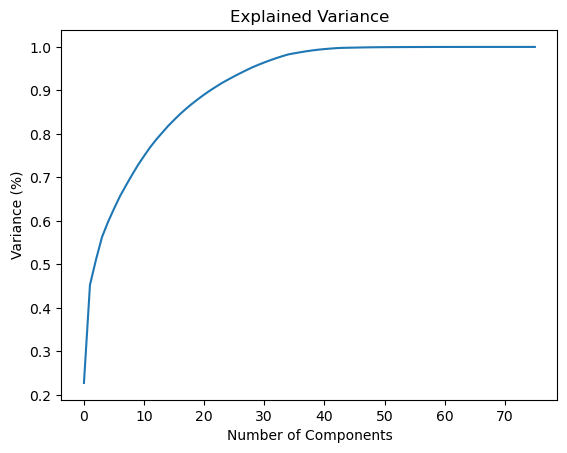

In [271]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(x_scaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

In [272]:
## keep 40 components
x_pca = PCA(40).fit_transform(x_scaled)

In [273]:
x_pca.shape

(4499, 40)

## Let's Build Some Models!
We'll compare them using the f1 score from sklearn to describe their accuracy.

In [274]:
## create our model accuracy scorer
scorer = make_scorer(f1_score, pos_label=None, average='weighted')

#### Naive Bayes

In [275]:
# Our data is continuous, so we'll use the Gaussian Classifier 
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [276]:
## print score
print('Average Gaussian NB F1: {}'.format((cross_val_score(gnb, x_pca, y, scoring=scorer)).mean()))

Average Gaussian NB F1: 0.6596552236622522


#### Decision Tree

In [277]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

In [278]:
## print score
print('Average Decision Tree F1: {}'.format((cross_val_score(clf, x_pca, y, scoring=scorer)).mean()))

Average Decision Tree F1: 0.5610078800848626


#### Random Forest

In [279]:
from sklearn import ensemble
rfc = ensemble.RandomForestClassifier()

In [280]:
## print score
print('Average Random Forest F1 score: {}'.format((cross_val_score(rfc, x_pca, y, scoring=scorer)).mean()))

Average Random Forest F1 score: 0.6267186238807549


#### KNN

In [281]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors=3)

In [282]:
## print score
print('Average KNN F1 score: {}'.format((cross_val_score(neighbors, x_pca, y, scoring=scorer)).mean()))

Average KNN F1 score: 0.545482612163396


c:\Users\Jason Huang\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\Jason Huang\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. 

#### Multi-layer Perceptron

In [283]:
from sklearn.neural_network import MLPClassifier

In [284]:
# Establish and fit the model, with a single, 100 perceptron layer.
mlp100 = MLPClassifier(hidden_layer_sizes=(100,))
mlp1000 = MLPClassifier(hidden_layer_sizes=(1000,))

In [285]:
## print score
print('Average MLP100 F1 score: {}'.format((cross_val_score(mlp100, x_pca, y, scoring=scorer)).mean()))

c:\Users\Jason Huang\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Jason Huang\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Jason Huang\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Jason Huang\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Average MLP100 F1 score: 0.6213855609841162


c:\Users\Jason Huang\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [286]:
## print score
print('Average MLP1000 F1 score: {}'.format((cross_val_score(mlp1000, x_pca, y, scoring=scorer)).mean()))

c:\Users\Jason Huang\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Jason Huang\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Jason Huang\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Jason Huang\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Average MLP1000 F1 score: 0.6396086035596149


c:\Users\Jason Huang\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Model Performance
The Naive Bayes model was the most accurate at 65%, with random forest and the MLP neural network just under that. Moving forward I'll continue to tinker these three models to try to boost performance, but we're at an acceptable level of prediction power to begin the real test, which is to apply our predictions to the current NBA season, and calculate how much money our model would (hopefully) win with an equal bet on each game.

I think the simple Naive Bayes model is performing better than others because of our limited sample size. I believe this is the same reason why the TensorFlow NN is underperforming. Unfortunately, even adding more seasons to our training data wouldn't improve performance, because the NBA game has been changing so rapidly in style of play, that these data available from three seasons ago and beyond lose relevance to predicting the winner.

## My Own implementation - Transformer Classifier

In [287]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, num_features, num_classes, dim_model=64, num_heads=4, num_layers=3, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.linear_in = nn.Linear(num_features, dim_model)
        self.pos_encoder = PositionalEncoding(dim_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=dim_model, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.linear_out = nn.Linear(dim_model, num_classes)

    def forward(self, x):
        x = self.linear_in(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.linear_out(x)
        return x




In [288]:
# Function to calculate accuracy
def calculate_accuracy(y_true, y_pred):
    predicted = torch.argmax(y_pred, dim=1)
    correct = (predicted == y_true).float().sum()
    return correct / y_true.shape[0]

In [289]:

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score


X_tensor = torch.tensor(x_scaled)
print(X_tensor.dtype)
y_tensor = torch.tensor(y.astype(float).to_numpy())
# Create DataLoader for batch processing
batch_size = 32
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_features = 76
num_classes = 2

# Check for GPU availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model and move it to the device (GPU or CPU)
model = TransformerClassifier(num_features=num_features, num_classes=num_classes)
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Function to calculate accuracy
def calculate_accuracy(y_true, y_pred):
    predicted = torch.argmax(y_pred, dim=1)
    correct = (predicted == y_true).float().sum()
    return correct / y_true.shape[0]

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    total_loss = 0
    total_accuracy = 0
    all_predictions = []
    all_targets = []
    for batch, (inputs, targets) in enumerate(dataloader):
        # Move data to device
        inputs, targets = inputs.to(device).float(), targets.to(device).long()

        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate batch loss and accuracy
        total_loss += loss.item()
        accuracy = calculate_accuracy(targets, outputs)
        total_accuracy += accuracy.item()

        # Collect predictions and true labels
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

    average_loss = total_loss / len(dataloader)
    average_accuracy = total_accuracy / len(dataloader)
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Save the model after training
torch.save(model.state_dict(), 'transformer_classifier.pth')

torch.float64
Using device: cuda
Epoch 1/30, Loss: 0.7138, Accuracy: 0.7895, Precision: 0.5885, Recall: 0.9260, F1 Score: 0.7196
Epoch 2/30, Loss: 0.6847, Accuracy: 0.6842, Precision: 0.5891, Recall: 0.9592, F1 Score: 0.7299
Epoch 3/30, Loss: 0.6792, Accuracy: 0.4737, Precision: 0.5890, Recall: 1.0000, F1 Score: 0.7414
Epoch 4/30, Loss: 0.6796, Accuracy: 0.4737, Precision: 0.5890, Recall: 1.0000, F1 Score: 0.7414
Epoch 5/30, Loss: 0.6789, Accuracy: 0.7895, Precision: 0.5889, Recall: 0.9996, F1 Score: 0.7412
Epoch 6/30, Loss: 0.6783, Accuracy: 0.6842, Precision: 0.5890, Recall: 1.0000, F1 Score: 0.7414
Epoch 7/30, Loss: 0.6775, Accuracy: 0.6316, Precision: 0.5890, Recall: 1.0000, F1 Score: 0.7414
Epoch 8/30, Loss: 0.6775, Accuracy: 0.6316, Precision: 0.5890, Recall: 1.0000, F1 Score: 0.7414
Epoch 9/30, Loss: 0.6782, Accuracy: 0.5789, Precision: 0.5890, Recall: 1.0000, F1 Score: 0.7414
Epoch 10/30, Loss: 0.6782, Accuracy: 0.3684, Precision: 0.5890, Recall: 1.0000, F1 Score: 0.7414
Epoch 

# Real World Application
Now that we have our prediction model, let's implement it to see how much hypothetical money we make! For simplicity, we'll assume we bet $100 on each prediction. This is calculated as follows:

Underdog Bet (positive odds):
 - Potential Payout = Wager Amount x (Odds/100) + Wager Amount.

Favorite Bet (negative odds):
 - Potential Payout = Wager Amount / (absolute value(Odds)/100) + Wager Amount

However, our cumulative total will only calculate profit.

In [290]:
# declare features, scale and pca
x_test = nba_test[features]
x_test_scaled = scaler.fit_transform(x_test)
x_test_scaled_pca = PCA(40).fit_transform(x_test_scaled)

In [291]:
# fit to training data and predict for current season
nba_test['predictions'] = gnb.fit(x_pca, y).predict(x_test_scaled_pca)

C:\Users\Jason Huang\AppData\Local\Temp\ipykernel_11944\9465778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_test['predictions'] = gnb.fit(x_pca, y).predict(x_test_scaled_pca)


Here our model correctly picked 56% of games from the current 2019-20 season.

In [292]:
## correct pct picks
len(nba_test[nba_test['predictions']==nba_test['homeWin']])/len(nba_test)

0.5406779661016949

In [293]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader

# Assuming TransformerClassifier is defined and loaded with trained weights

# Prepare your test data
# Assuming x_test_scaled_pca and nba_test are defined and x_test_scaled_pca is a NumPy array or a Pandas DataFrame
# x_test_tensor = torch.tensor(x_test_scaled_pca).float()
x_test_tensor = torch.tensor(x_test_scaled).float()


test_dataset = TensorDataset(x_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32)  # You can adjust the batch size

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and set it to evaluation mode
model = TransformerClassifier(num_features=num_features, num_classes=num_classes)
model.load_state_dict(torch.load('transformer_classifier.pth'))  # Load your trained model weights
model.to(device)
model.eval()

# Make predictions on the test set
predictions = []
with torch.no_grad():
    for inputs in test_dataloader:
        inputs = inputs[0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Store predictions in the DataFrame
nba_test['predictions'] = predictions


C:\Users\Jason Huang\AppData\Local\Temp\ipykernel_11944\2846257617.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_test['predictions'] = predictions


In [294]:
## correct pct picks
len(nba_test[nba_test['predictions']==nba_test['homeWin']])/len(nba_test)

0.5406779661016949

In [295]:
## create an empty money won column
nba_test['moneyWon'] = 0

C:\Users\Jason Huang\AppData\Local\Temp\ipykernel_11944\142933246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_test['moneyWon'] = 0


In [296]:
## calculate money won
for i in nba_test.index:
  ## check for correct pick
  if nba_test['predictions'].iloc[i] == nba_test['homeWin'].iloc[i]:
    ## correct home win
    if nba_test['homeWin'].iloc[i] == True:
      ## home is favored
      if nba_test['homeOdds'].iloc[i] < 0:
        nba_test.at[i, 'moneyWon'] = (100 / ((abs(nba_test['homeOdds'].iloc[i]))/100))
      ## home is underdog
      elif nba_test['homeOdds'].iloc[i] > 0:
        nba_test.at[i, 'moneyWon'] = (100 * ((nba_test['homeOdds'].iloc[i])/100))
      ## even odds
      elif nba_test['homeOdds'].iloc[i] == 0:
        nba_test.at[i, 'moneyWon'] = 100
    ## correct away win
    if nba_test['homeWin'].iloc[i] == False:
      ## away is favored
      if nba_test['awayOdds'].iloc[i] < 0:
        nba_test.at[i, 'moneyWon'] = (100 / ((abs(nba_test['awayOdds'].iloc[i]))/100))
      ## away is underdog
      elif nba_test['awayOdds'].iloc[i] > 0:
        nba_test.at[i, 'moneyWon'] = (100 * ((nba_test['awayOdds'].iloc[i])/100))
      ## even odds
      elif nba_test['awayOdds'].iloc[i] == 0:
        nba_test.at[i, 'moneyWon'] = 100
  ## incorrect pick
  elif nba_test['predictions'].iloc[i] != nba_test['homeWin'].iloc[i]:
    nba_test.at[i, 'moneyWon'] = -100

C:\Users\Jason Huang\AppData\Local\Temp\ipykernel_11944\3705461351.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_test.at[i, 'moneyWon'] = (100 / ((abs(nba_test['homeOdds'].iloc[i]))/100))


In [297]:
## create cumulative money won column
nba_test['cumTotalWon']  = nba_test['moneyWon'].cumsum()

C:\Users\Jason Huang\AppData\Local\Temp\ipykernel_11944\3564126491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_test['cumTotalWon']  = nba_test['moneyWon'].cumsum()


In [298]:
# check work
nba_test[['predictions','homeWin','homeOdds','awayOdds','moneyWon','cumTotalWon']].head(10)

,predictions,homeWin,homeOdds,awayOdds,moneyWon,cumTotalWon
0,1,False,150,-180,-100.000000,-100.000000
1,1,False,-260,210,-100.000000,-200.000000
2,1,True,-105,-115,95.238095,-104.761905
3,1,True,-180,150,55.555556,-49.206349
4,1,True,-170,145,58.823529,9.617180
5,1,False,260,-330,-100.000000,-90.382820
6,1,True,-110,-110,90.909091,0.526271
7,1,False,-165,142,-100.000000,-99.473729
8,1,True,-150,130,66.666667,-32.807062
9,1,True,-350,275,28.571429,-4.235634


# Final Results!
We made almost \$15,000 with a $100 bet on every game! This is better than expected and is very exciting. It lost just over \$1,000 initially before it came back.

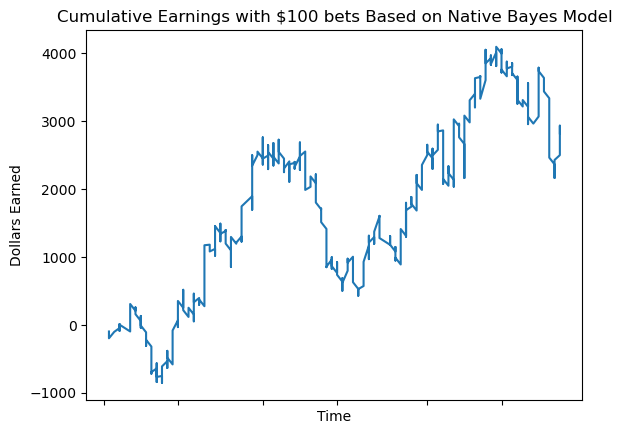

In [299]:
## plot the cumulative money won over time
fig, ax = plt.subplots()
plt.plot(nba_test['date'], nba_test['cumTotalWon'])
plt.title('Cumulative Earnings with $100 bets Based on Native Bayes Model')
plt.ylabel('Dollars Earned')
plt.xlabel('Time')
ax.tick_params(labelbottom=False)

In [213]:
print("The model's low point is {} dollars.".format(nba_test['cumTotalWon'].min()))
print("The model's high point is {} dollars.".format(nba_test['cumTotalWon'].max()))
print("The model has profited {} dollars this season.".format(nba_test['cumTotalWon'].iloc[-1]))

The model's low point is -979.6906445862803 dollars.
The model's high point is 17153.408504314128 dollars.
The model has profited 16448.420006499542 dollars this season.


Below are a few predicted huge upsets! 

In [84]:
## top 5 wins
nba_test[['date','homeTeam','awayTeam','predictions','homeWin','homeOdds','awayOdds','moneyWon']].loc[nba_test['moneyWon'] > 100].sort_values(by='moneyWon',ascending=False).head()

,date,homeTeam,awayTeam,predictions,homeWin,homeOdds,awayOdds,moneyWon
540,2020-01-20,CLE,NYK,False,False,-2500,1100,1100.0
459,2020-01-08,UTA,NYK,True,True,850,-1500,850.0
329,2019-12-21,DET,CHI,False,False,-1100,700,700.0
479,2020-01-11,OKC,LAL,False,False,-1000,650,650.0
413,2020-01-02,SAS,OKC,False,False,-1000,650,650.0


Here's some potentially dumb bets that we still got right.

In [85]:
## least money made on a bet
nba_test[['date','homeTeam','awayTeam','predictions','homeWin','homeOdds','awayOdds','moneyWon']].loc[nba_test['moneyWon'] > 0].sort_values(by='moneyWon').head()

,date,homeTeam,awayTeam,predictions,homeWin,homeOdds,awayOdds,moneyWon
120,2019-11-22,UTA,GSW,True,True,-3500,1300,2.857143
194,2019-12-02,PHI,UTA,True,True,-3000,1200,3.333333
499,2020-01-14,MEM,HOU,True,True,-1600,912,6.250000
103,2019-11-20,DEN,HOU,True,True,-1600,900,6.250000
85,2019-11-17,SAC,BOS,True,True,-1600,900,6.250000


# Conclusion
This model seems too good to be true. I continue to look for reasons to doubt these results because it has turned a $1,000 investment into almost \$15,000. One potential reason could be that the odds data was generous, so further vetting those numbers could be useful.

# Next Steps
I'm ready to deploy this model using my own money. Although I think I'll make it $5 bets just in case I've been extremely lucky so far. I'll need to find a betting site API in which I can set scripts up to load in the odds, make a prediction, and place my bet. 

# Further Improvements
- This model has yet to include any player data. A category that includes a rolling roster of top performers and whether they are out with injury or not could prove useful.
- More explanatory power in order to give a confidence rating on single game predictions. Currently the model relies on long term use with a bet on every game.
- Opting out of dumb bets. I could train the model to decide if a bet was worth the risk or not, instead of spreading that risk wide. The confidence interval could be used to compare against the odds.